# 微信数据统计分析

## 导入依赖库

In [36]:
import pickle
import random
import os
from PIL import Image
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
from wordcloud import WordCloud
import itchat
from threading import Thread as th
import jieba
import re
import json
from urllib.request import urlopen, quote
import webbrowser as web
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set(style="white", context="notebook")
sns.set_style('whitegrid', {'font.sans-serif':['simhei', 'Arial']})

## 登陆微信获取数据

In [2]:
itchat.auto_login()

Getting uuid of QR code.
Please scan the QR code to log in.
Please press confirm on your phone.
Loading the contact, this may take a little while.
Login successfully as 查永春


## 保存数据

In [ ]:
friends=itchat.get_friends(update=True)
with open("friends.data","wb")as fp:
    pickle.dump(friends,fp)

## 加载数据

In [4]:
with open("friends.data","rb")as fp:
    friends=pickle.load(fp)

print("Total {} friends.".format(len(friends)))

Total 652 friends.


## 城市数据

In [31]:
pro_city={}
for friend in friends:
    province=friend['Province']
    city=friend['City']
    pc=province+' '+city
    if pc in pro_city:
        pro_city[pc] += 1
    else:
        pro_city[pc] = 1
print(pro_city)

{'北京 东城': 4, '浙江 台州': 1, '上海 徐汇': 6, ' ': 186, '天津 ': 2, '北京 海淀': 27, '江苏 无锡': 3, '上海 黄浦': 4, '云南 临沧': 17, '上海 普陀': 2, '四川 泸州': 1, '上海 静安': 3, '贵州 安顺': 2, '安徽 亳州': 2, '上海 闵行': 49, '上海 ': 18, '上海 金山': 1, '四川 绵阳': 1, '广东 广州': 14, '天津 南开': 2, '浙江 杭州': 10, '广东 深圳': 8, '湖北 武汉': 9, '四川 成都': 14, '浙江 温州': 2, 'SanFrancisco 旧金山': 1, '上海 浦东新区': 14, '山东 济南': 3, '湖南 衡阳': 3, '云南 昆明': 9, '浙江 宁波': 3, 'Styria ': 1, '福建 龙岩': 1, '辽宁 沈阳': 1, '北京 ': 11, '陕西 西安': 5, '北京 朝阳': 18, '北京 大兴': 2, '云南 普洱': 1, '云南 保山': 1, '湖北 宜昌': 2, '山东 烟台': 1, 'Wan Chai ': 1, '江苏 南京': 5, '黑龙江 哈尔滨': 5, '安徽 阜阳': 1, '重庆 江北': 2, '江西 上饶': 2, '浙江 嘉兴': 1, 'California Los Angeles': 1, 'New Jersey Others': 1, '山东 青岛': 6, '湖南 岳阳': 2, 'Offaly ': 1, '江苏 南通': 2, '福建 泉州': 4, '广东 茂名': 2, '山西 太原': 2, '江西 南昌': 2, 'New South Wales Sydney': 1, '江苏 苏州': 2, '福建 漳州': 1, '上海 嘉定': 3, '山东 东营': 1, '浙江 湖州': 3, '福建 福州': 3, '上海 松江': 3, 'Longford ': 1, 'Pennsylvania Pittsburgh': 1, 'Lyon ': 1, 'Illinois Chicago City': 1, '重庆 黔江': 1, '江苏 扬州': 1, '山东 潍坊': 2, '广

## 下载头像

In [26]:
def download_icon(user_name,icon_name):
    img = itchat.get_head_img(userName=user_name)
    with open(icon_name,"wb") as fp:
        fp.write(img)

if not os.path.isdir("img"):
    os.mkdir("img")
t_pool=[]
print('Using multiple threads to download images...')
for index,friend in enumerate(friends):
    t=th(target=download_icon,args=(friend["UserName"],"img/{:0>3d}.jpg".format(index+1)))
    t.start()
    t_pool.append(t)

for index,t in enumerate(t_pool):
    print("\rProcessing：["+"="*(index//10)+">]"+"{:.2f}%".format((index+1)/len(friends)*100),end="",flush=True)
    t.join()
print("\nDownload images done.")

Using multiple threads to download images...
Processing：[=================================================================>]100.00%
Download images done.


### 拼接头像

In [9]:
def createImg():
    x = 0
    y = 0
    size=3000
    img_dir=os.path.abspath("img")
    imgs = [os.path.join(img_dir,img) for img in os.listdir(img_dir)]
    random.shuffle(imgs)
    new_img = Image.new('RGBA', (size, size))
    width = int(math.sqrt(size * size / len(imgs)))
    num_line = int(size / width)
    for index,img_path in enumerate(imgs):
        print("\rHandling：["+"="*(index//10)+">]"+"{:.2f}%".format((index+1)/len(imgs)*100),end="",flush=True)
        try:
            img = Image.open(img_path)
        except:
            continue
        img = img.resize((width, width), Image.ANTIALIAS)
        new_img.paste(img, (x * width, y * width))
        x += 1
        if x >= num_line:
            x = 0
            y += 1

    new_img.save("all.png")
    return new_img

im=createImg()
im.show()

Handling：[=================================================================>]100.00%

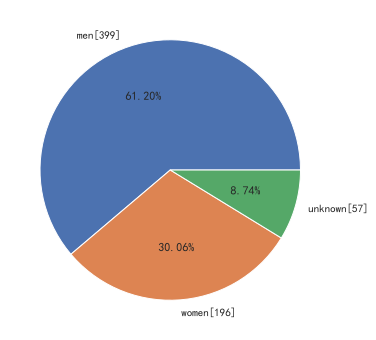

In [24]:
def getSex():
    sex = dict()
    for f in friends:
        if f["Sex"] == 1: # man
            sex["men"] = sex.get("men", 0) + 1
        elif f["Sex"] == 2: # women
            sex["women"] = sex.get("women", 0) + 1
        else: # unknown
            sex["unknown"] = sex.get("unknown", 0) + 1
    return sex
sex=getSex()
df=pd.DataFrame.from_dict(sex,orient="index",columns=["num"])
num=df["num"].values
text=df.index.tolist()
labels=list(map(lambda x: str(x[1])+"["+str(x[0])+"]", zip(num, text)))
plt.figure(figsize=(6,6))
plt.pie(df["num"],labels=labels,autopct="%3.2f%%")
plt.show()

In [29]:
def getSignature():
    with open('sign.txt', 'a', encoding='utf-8') as file:
        for f in friends:
            signature = f["Signature"].strip().replace("emoji", "").replace("span", "").replace("class", "")
            rec = re.compile("1f\d+\w*|[<>/=]")
            signature = rec.sub("", signature)
            file.write(signature + "\n")

def create_word_cloud(filename):
    with open("{}.txt".format(filename), encoding='utf-8') as fp:
        text=fp.read()
    for line in text.split('\n'):
        print(line)
    text=re.sub(r"(\n)+","\n","\n".join(jieba.cut(text))) # 分词
    wc = WordCloud(
        background_color="white",
        max_words=2000,
        font_path='C:\\Windows\\Fonts\\simfang.ttf',
        height=1000,
        width=1000,
        max_font_size=80,
        random_state=50,
    )
    myword = wc.generate(text)
    wc.to_file('signature.png')
    os.system('start signature.png')
getSignature()
create_word_cloud("sign")

读万卷书，行万里路！
稀里糊涂未必不好,,Ծ^Ծ,,

sgjfetifchhfb

爱水果，爱健康，爱生活
最喜欢的告别方式  “明天再见”

揪心！

18811225058
WHY NOT ?


我是一个努力干活，还不黏人的小妖精


像硬汉一样学习和生活。

总是在做事吧~

Diamonds or rust
管好自己
没有陌生人的世界

爱你所爱 行你所行 听从你心 无问西东


Wer die Wahl hat,hat die Qual

翻山越岭，触摸到云

人生就是一段旅程


曾经沧海难为水
除却巫山不是云
法学研究和大数据技术的跨界者。能出成果，出好成果
一定是特别的缘分，才可以一路走来变成一家人
佛着

技术时代的思行者！
为时未晚
衷心诉了春过半，平生光影短。


随风飘散

沧海横流，方显英雄本色。树高万丈不忘根，人若辉煌不忘本！



等待人生的第一笔单




活不过一集，死于话多。
无人为你挡枪口,那就做自己的英雄。
13421849900

是你自恋

玻璃晴朗，橘子辉煌

烦恼会解决烦恼
天天睡不醒
唯愿踏实且勤恳。



让坚持成为一种习惯
专注、沉着、耐心、舍得
生命太短，没时间留给遗憾！！
多年以后。。。。
我的栗子呢🌰
正大方圆
无始心熏染，心如影像般，纵现外境相，如实见境无。
25571765677776765

You mistake stars reflected in a pond for the night sky
简单专注
我遇见谁会有怎样的对白？
春暖花开

机会难得，失去却很容易。
不舍爱与自由
不常在线，有急事直接电话
我就是我



Work hard, play harder！

夏虫不可语冰





无人知晓  偏安一隅


昨夜星辰昨夜风。

幸福并感激着

我叫阮钦

永结无情游，相期邈云汉

KEEP TRYING. PLAY AROUND.

丧
太阳公公出来了
不念过往，不畏将来

请先说你好


我在这里啊。
都来找我玩
做好当前
开心就好！
1124


keep your spirit soaring high
日啖鱼干三百斤，不辞长做喵星人a

生活是苦难的，我又划着我的断桨出发了

英雄也投降
桃栗三年柿八年 达摩九年我一生

学习一个
不好好学习你就是狗！
？？？
开心就好

汇添富基金
CFA


谁能任性不认命
未填写
引领时代浪潮，才是技术领域的至高玩法。
While we have another heart to conquer the whole universe

恬淡虚无，真气重支
面向对象面向君
不负代码不负卿
i can do this all day

风和日丽是偶然

深度懒癌，努力起床！
常抬头看阳光，努力工作，快乐生活


性别：男
“Life is a pure flame.”

不气馁 有召唤 爱自由
Good things come to those who wait

学习学习再学习
经历是人生的财富

收心 · 清心 · 静心

小树丫丫，要像一棵树栽在溪水旁，按时候结果子，叶子也不枯干。
当全世界都放弃你的时候你都不能放弃你自己


小宝在舔血谁能缝补谁又能听见

谢谢你的一切
PHPer
灵魂的自由才是这真正的自由
已所不欲勿施于人


这个人很懒，写了也等于没写。

因为相信，所以看见
Dare to take
不将就，不强求，尽人事，听天命
流泪撒种的，必欢呼收割


关山难越，萍水相逢
水(活在当下)
知命不惧！
世间本无路，走的人多了就有路，世间本有路，走的人少了，就无路



What gets you here cannot get you there
你永远比你最瘦的时候更胖

不忮不求
男人一生只做两件事

修行
先取山西十二州
我是
优雅是一种阅历，淡然是一种沉淀
不能～
静观风雨天下 不慕一生浮华
3年.. 不适时宜地坚定且不遗
破&amp;立
春雪满空来，触处似花开



天下难事，必做于易;天下大事，必做于细。
坚持企盼，继续善良，仍旧浪漫。
拥有再大的野心，你现在也只能卑微的活着！

Build your dreams
责任
用心对己，以心待人
划船不用桨 人生全靠浪
Good good study
重新发现、定义并创造这个世界…


对待生命 你不妨大胆一些 因为我们终将失去它
行为即目的
竖子，不足与谋。
前半生，不害怕、后半生，不后悔
 " 2600"️
谨言慎行，戒急用忍


让自己变得更好更强最重要！
知福
风中叶子，随风飘舞。风起叶舞，风停叶落。叶落归根，无怨无悔。
愿为你，上九天揽月；愿为你，下五洋捉鳖٩(˃̶͈̀௰˂̶͈́)
。。。。。。。
U see u

你陪我走过风雨，我陪你一世温柔



be yourself
强大到无须依靠他人
朱文峰
？？
无
Everything isn't getting along well, your efforts paid off.
蹄驰步稳
静下心。。慢慢来
多做笔记
逐梦
Keep your dream...
谋定而后动，不能不思考，也不能思考太久
不要相信故事，要相信自己。
牢记初心，不忘使命
人活一口气，可接下来的每一天我都将屈辱的活着
在未来面前 我们都只是孩子



临渊慕鱼，不如退而结网!
时空行为研究
睡一觉就失忆一点也不好
谈笑一水隔，赛艇两洲间。睿智的P社玩家+1000。

lloviendo en Macondo
額
The truth is more wonderful
闭门炼丹中 loading...
苍山似海峰为浪
晓雾如云客是仙
知行合一

容易，包容变化，不止简单!
算法真难
风里雨里，守护着你～
平静比快乐重要
一切从心!

千淘万漉虽辛苦，吹尽黄沙始到金。
()。
这个有意思～
自律即自由
攻克己身 叫身服我
若不至天竺，终不东归一步
追寻一起
活在当下！
單純的眼睛看到清澈的世界
Hello kitty hello hello hello kitty
梦里不知身是客，一晌贪欢
致虚守静，知行合一

用心用心用心！！！

一手免佣，全上海一手代理，17721306750
何も捨てることができない人には、何も変えることできない。

Just follow your heart.心
心里有彩虹 " "


光
从容的让自己生活的更深刻一些
A NEW START
谦卑，是懂得尊重别人；
自信，是懂得尊重自己。
士不可以不弘毅，任重而道远
独自走进陆家嘴丿
学习外语，天天向上

p p
 " " " " " "



心好累
每天早上起床是为了比昨天更开心，


好好加油认真生活！
Keep running.
～～～～～
嗯
敬畏之心
如何做一个有思想的人？
O(∩_∩)O

要加油呀ฅ( ̳• ε • ̳)ฅ
一切有为法，如梦幻泡影，如露亦如电，应作如是观
勿以恶小而为之，勿以善小而不为。
既然认准一条道路，何必去打听要走多久。

另一位更能吃的五讲四美朝阳群众
别说我没头像
坚信实干而非投机，坚信梦想而非功利。
云青波素，玉老田荒。
深活
没有礁

握不住的沙，干脆扬了它！
全朝阳区恩格尔系数第一名




平生多磨砺，男儿自横行。
思维的浅陋让我们的语言变得粗俗而有失精准

区块链 code is law


笼中雀
听老婆的话，跟党走，永远有饭吃

简单

Winners never quit. Quiters never win.
学历-》职场-》职场收入-》投资理财-》财富自由，递进的敲门砖
不畏将来，不念过往。
救赎



握紧方向舵，做真正的我！

欲求其中，先求其上；欲求其上，必求上上！

没关系你也不用给我机会



耐心farm

积累  沉淀  绽放
无论何时，选择做好自己。
Andy
Do not go gentle into that good night -- Dylan Thomas


咱把牛逼还给🐂，大家还是好朋友👭
却原来是司马发来的兵
终生学习，然后等待时间的回报
简单 极致

美岑的守护神
2018, 再也不见了，我们……

你陪我走过风雨，我陪你一世温柔



be yourself
强大到无须依靠他人
朱文峰
？？
无
Everything isn't getting along well, your efforts paid off.
蹄驰步稳
静下心。。慢慢来
多做笔记
逐梦
Keep your dream...
谋定而后动，不能不思考，也不能思考太久
不要相信故事，要相信自己。
牢记初心，不忘使命
人活一口气，可接下来的每一天我都将屈辱的活着
在未来面前 我们都只是孩子



临渊慕鱼，不如退而结网!
时空行为研究
睡一觉就失忆一点也不好
谈笑一水隔，赛艇两洲间。睿智的P社玩家+1000。

lloviendo en Macondo
額
The truth is more wonderful
闭门炼丹中 loading...
苍山似海峰为浪
晓雾如云客是仙
知行合一

容易，包容变化，不止简单!
算法真难
风里雨里，守护着你～
平静比快乐重要
一切从心!

千淘万漉虽辛苦，吹尽黄沙始到金。
()。
这个有意思～
自律即自由
攻克己身 叫身服我
若不至天竺，终不东归一步
追寻一起
活在当下！
單純的眼睛看到清澈的世界
Hello kitty hello hello hello kitty
梦里不知身是客，一晌贪欢
致虚守静，知行合一

用心用心用心！！！

一手免佣

晚来天欲雪，能饮一杯无？
吹面不寒杨柳风


空谈误国，实干兴邦。冒险家。

人生呐，于不如意之时，思如意之事；
人生很长，积极向阳！


生活就像一面镜子，你对他笑，他就会对你笑！
身体安康很重要

溯洄从之，道阻且长。
我怕我只是只夏虫啊，快给我讲讲冬天的雪吧！
相信雨后有彩虹 " "
 " "
等不到天黑，看不见你流泪
人生 苦短 要 勇敢  翻 一座山  追 一个梦  爱  一个人
幸福并感激着

来日方长


未曾谋面
       可会思念
桃栗三年柿八年 达摩九年我一生
2020.11





杯中有冰可乐就好！
let life live
？？？
Doing is faster than watching. Iterate.
添加请说明来意，为避免骚扰，没有说明的直接忽略，不通过~

本号已满，加jingyun135135，朋友圈都是一样的。



嘿
专心、专注、专业
博观约取，厚积薄发
微分现实，积分理想
稀疏生活，聚类梦想


做个对社会有用的人
视此虽近 邈若山河
1124
夏虫不可语冰
我只是个蛇精宝宝
13852403657
微博：八度音乐夏泽宇      吉他教学，吉他销售，买琴有优惠
我宁愿做错，也不愿什么都不做。
祸莫大于不知足 咎莫大于欲得 故知足不足，常足矣

为天地立心、为生民立命、为往圣继绝学、为万世开太平。


此号不常用
新号19188336790
社会人
Nothing to say
最大的问题是想得太多做得太少
我是一个努力干活，还不黏人的小妖精



幸福不止在于丰衣足食，更在于碧水蓝天





当你有了足够的勇气，可能就会有足够的运气。
What do we say to the god of death？
凭主意行
王秉寰
蓝翔三年级挖掘二班，精通各种挖掘机
湖海意悠悠，烟波下钓钩。
今天不做的事 明天也不会做了
tomorrow will be a better day
兼具匠人精神与商业思维

never say goodbye

近乎直觉的热情
谢谢你来看我呀~~
一生努力，一生坚持，想要的都拥有，得不到的都释怀。
竹杖芒鞋轻胜马，谁怕？一蓑烟雨任平生

生活，不会亏待努力奋斗的人!
为梦想而生


Un artiste c’est toujours seul
有趣的灵魂
严以修身严以用权严以律己谋事


Valar Morghulis
票圈关闭
我必须是你近旁的一株木棉，作为树的形象和你站在一起。
WHY NOT ?

任重道远
hey，there


Later equals never
成长是最好的目标
十年饮冰，难凉热血！


？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？

不舍爱与自由

张德祥骥智无人驾驶ALLInCreateAmind.agi.top强化学习
勇毅专精，勤慎公忠



苦难并不是财富，对苦难的思考才是。
想过成功，想过失败，但从没想过放弃。
吾心向山，君心向水
秘果
それでもうなずきながら
独立而自由的灵魂
n 55iw ! n paau ! n a∧07 !

你拿倒了呢
阳光正好。
When I see your eyes  " "
I’m a ferrari
带上牧马人，穿越罗布泊，倒在亚马逊，这就是我的梦想
孤鴈

♪( ´θ｀)ノ
adjust
专注、沉着、耐心、舍得
终身学习
《练琴》工作室Michael老师



若万事俱备，你的价值何在
Big寶运 out!
是你自恋

学生党一枚
玻璃晴朗，橘子辉煌
每个人都在奋不顾身，不是只有你受尽委屈
数码 " " 音乐 " " 拍照 " "  骑行🚴🏻真正优秀的人，从不抱怨。
生如夏花之绚烂，死如秋叶之静美

Life is tough，you must be tougher than it.
不要有为难情绪嘛
To file the hour - that is happiness
专心做事
衷心诉了春过半，平生光影短。
人生无根蒂 飘如陌上尘
早起有益
坚守本心，无问西东
JW’s  " "          ִ
znxfxy
多年以后。。。。
808bass  一只猫 " " 爪踏入豪门的加菲猫 " "
小牛向前冲后，小马再奔腾。
上班时间上午九点至七点。周二休息
春暖花开
复得返自然

水逆退散
最喜欢的告别方式  “明天再见”
我叫阮钦
┗y ~o l o つ
———自律给自己自由———      ִ
生活有望穿秋水的期待，
    也会有意想不到的欣喜。
24小时内统一通过好友，不要着急～
敬天爱人
年年岁岁
当生活给你一百个理由哭泣时，你就拿出一千个理由笑给它看。

这个人不是一般的懒
情为何物，生死相许！
───该朋友圈仅对你开放───
 山河滚烫

In [37]:

# 根据地名获得经纬度信息
def GetLngLat(address):
    url = 'http://api.map.baidu.com/geocoder/v2/'
    output = 'json'
    ak = 'x2ZTlRkWM2FYoQbvGOufPnFK3Fx4vFR1'
    add = quote(address)
    uri = url + '?' + 'address=' + add + '&output=' + output + '&ak=' + ak
    try:
        req = urlopen(uri)
    except ConnectionRefusedError as e:
        return e
    res = req.read().decode()
    temp = json.loads(res)  # 对json数据进行解析
    return temp

# 可视化热力图html代码
def html_code():
    head = '''<!DOCTYPE html>\n<html>\n<head>\n    <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />\n    <meta name="viewport" content="initial-scale=1.0, user-scalable=no" />\n    <script type="text/javascript" src="http://gc.kis.v2.scr.kaspersky-labs.com/C8BAC707-C937-574F-9A1F-B6E798DB62A0/main.js" charset="UTF-8"></script><script type="text/javascript" src="http://api.map.baidu.com/api?v=2.0&ak=x2ZTlRkWM2FYoQbvGOufPnFK3Fx4vFR1"></script>\n    <script type="text/javascript" src="http://api.map.baidu.com/library/Heatmap/2.0/src/Heatmap_min.js"></script>\n    <title>热力图功能示例</title>\n    <style type="text/css">\n		ul,li{list-style: none;margin:0;padding:0;float:left;}\n		html{height:100%}\n		body{height:100%;margin:0px;padding:0px;font-family:"微软雅黑";}\n		#container{height:500px;width:100%;}\n		#r-result{width:100%;}\n    </style>	\n</head>\n<body>\n	<div id="container"></div>\n	<div id="r-result">\n		<input type="button"  onclick="openHeatmap();" value="显示热力图"/><input type="button"  onclick="closeHeatmap();" value="关闭热力图"/>\n	</div>\n</body>\n</html>\n<script type="text/javascript">\n    var map = new BMap.Map("container");          // 创建地图实例\n\n    var point = new BMap.Point(105.418261, 35.921984);\n    map.centerAndZoom(point, 5);             // 初始化地图，设置中心点坐标和地图级别\n    map.enableScrollWheelZoom(); // 允许滚轮缩放\n  \n    var points =['''
    rear = ''']\n   \n    if(!isSupportCanvas()){\n    	alert('热力图目前只支持有canvas支持的浏览器,您所使用的浏览器不能使用热力图功能~')\n    }\n	//详细的参数,可以查看heatmap.js的文档 https://github.com/pa7/heatmap.js/blob/master/README.md\n	//参数说明如下:\n	/* visible 热力图是否显示,默认为true\n     * opacity 热力的透明度,1-100\n     * radius 势力图的每个点的半径大小   \n     * gradient  {JSON} 热力图的渐变区间 . gradient如下所示\n     *	{\n			.2:'rgb(0, 255, 255)',\n			.5:'rgb(0, 110, 255)',\n			.8:'rgb(100, 0, 255)'\n		}\n		其中 key 表示插值的位置, 0~1. \n		    value 为颜色值. \n     */\n	heatmapOverlay = new BMapLib.HeatmapOverlay({"radius":20});\n	map.addOverlay(heatmapOverlay);\n	heatmapOverlay.setDataSet({data:points,max:10});\n	//是否显示热力图\n    function openHeatmap(){\n        heatmapOverlay.show();\n    }\n	function closeHeatmap(){\n        heatmapOverlay.hide();\n    }\n	openHeatmap();\n    function setGradient(){\n     	/*格式如下所示:\n		{\n	  		0:'rgb(102, 255, 0)',\n	 	 	.5:'rgb(255, 170, 0)',\n		  	1:'rgb(255, 0, 0)'\n		}*/\n     	var gradient = {};\n     	var colors = document.querySelectorAll("input[type='color']");\n     	colors = [].slice.call(colors,0);\n     	colors.forEach(function(ele){\n			gradient[ele.getAttribute("data-key")] = ele.value; \n     	});\n        heatmapOverlay.setOptions({"gradient":gradient});\n    }\n	//判断浏览区是否支持canvas\n    function isSupportCanvas(){\n        var elem = document.createElement('canvas');\n        return !!(elem.getContext && elem.getContext('2d'));\n    }\n</script>'''

    return head, rear
def view_map(pro_city):
    # 显示城市分布,使用百度的api获得相应城市的经纬度，然后使用heatmap.json生成热力图，返回html文件
    json_data = ''
    # 把城市数据转为经纬度
    for city, value in pro_city.items():
        try:
            pos = GetLngLat(city)
        except ConnectionError:
            pos = None
        if pos is not None and pos['status'] == 0:
            lng = pos['result']['location']['lng']
            lat = pos['result']['location']['lat']
            json_temp = '{"lng":' + str(lng) + ',"lat":' + str(lat) + ', "count":' + str(value) + '}, '
            json_data += '\n' + json_temp

    # 生成html格式热力图文件
    try:
        head, rear = html_code()
        html_file = head + json_data + rear
        with open('heatmap.html', 'w', encoding='utf-8') as f:
            f.write(html_file)
            # 网页显示
            web.open('heatmap.html', new=0, autoraise=True)
    except AttributeError:
        return AttributeError

view_map(pro_city)